code: https://github.com/ritts97/Unsupervised-Face-Clustering

## Setup

In [1]:
import sys
import os
import dlib
import glob
import time

import cv2
import os

import matplotlib.pyplot as plt

from face_classifier import FaceClassifier

import random
import torch
import numpy as np

import calc
import icio
import postproc

from person_db import Person
from person_db import Face
from person_db import PersonDB

print(dlib.DLIB_USE_CUDA)
print(cv2.__version__)

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


True
4.5.5


In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = False  # type: ignore

seed_everything(79)

## Extract frame from video and save as images

In [3]:
filepath = '/opt/ml/project/test_videos/giha_before_13m.mp4'
video = cv2.VideoCapture(filepath)

assert video.isOpened(), f"Could not Open : {filepath}"

In [4]:
# 불러온 비디오 파일의 정보 출력
length = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv2.CAP_PROP_FPS)

print("length :", length)
print("width :", width)
print("height :", height)
print("fps :", fps)

length : 19153
width : 1280
height : 720
fps : 23.999999665848698


In [5]:
# 변수 설정
frame_id = 0
capture_interval = 2 * int(round(fps)) # n초 간격 프레임 캡쳐
stop = 300 # 0 초과의 정수 지정 시 n 초 까지만 영상 실행
skip = 0 # 초반 n 초 skip
capture_cnt = 60 # 몇 장의 frame을 capture 할 지
threshold = 0.36 # 같은 인물로 판단할 threshold -> 낮을수록 같은 인물로 판단하지 않음
ratio = 1.0 # resizing ratio인데, 건드리지 않는게 좋을 듯
running = True

In [6]:
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18'
# pdb = PersonDB()
# pdb.load_db(result_dir)
# pdb.print_persons()

In [7]:
try:
    if not os.path.exists(result_dir):
        os.makedirs(result_dir)
except OSError:
    print('Error: Creaing directory. ' + result_dir)

**dnn_superres 사용**
```
pip uninstall opencv-python
pip uninstall opencv-contrib-python
pip3 install opencv-contrib-python
```
- 코드 및 성능비교표: https://learnopencv.com/super-resolution-in-opencv/ 
- super resolution 모델들 & 다운로드 링크: https://github.com/opencv/opencv_contrib/blob/master/modules/dnn_superres/README.md

In [8]:
video = cv2.VideoCapture(filepath) 

# FaceClssifier 인스턴스 생성
fc = FaceClassifier(threshold, ratio, result_dir)

fingerprints = dict()

cnt = 0
total_start_time = time.time()
while running:
    ret, frame = video.read()

    if frame is None:
        break

    frame_id += 1
    if frame_id % capture_interval != 0:
        continue

    seconds = int(round(frame_id / fps, 3))
    print(f"Running in {seconds} sec in video...")
    if seconds > stop > 0:
        break
    if seconds < skip:
        continue

    start_time = time.time()

    # 얼굴 디텍션 -> 얼굴 인코딩(frame, face_boxes) -> 옷 디텍션 -> 옷 인코딩(read_frames 코드 + _frame_worker 코드 + get_model 코드 + fingerprint 코드) -> 이미지 저장
    # 반환: 상체 이미지(파일명): [얼굴 인코딩 | 옷 인코딩] (fingerprint)
    frame_fingerprints = fc.detect_faces(frame)

    if frame_fingerprints:
        fingerprints.update(frame_fingerprints)
        print('Face images: ', len(fingerprints))
        cnt += 1
        print('frame_cnt: ', cnt)
        print()
        
        # break

    if cnt >= capture_cnt:
        break



# restore SIGINT (^C) handler
running = False
video.release()
total_elapsed_time = time.time() - total_start_time
print()
print("total elapsed time: %.3f second" % total_elapsed_time)

# pdb.save_db(result_dir)
# pdb.print_persons()


print("Captured frames : ", frame_id)

Running in 2 sec in video...
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082941.966-0.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082941.966-1.png
Face images:  2
frame_cnt:  1

Running in 4 sec in video...
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082943.204-0.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082943.204-1.png
Face images:  4
frame_cnt:  2

Running in 6 sec in video...
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082943.820-0.png
image saved path:  /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082943.820-1.png
Face images:  6
frame_cnt:  3

Running in 8 sec in video...
image

In [9]:
filepath = '/opt/ml/project/test_videos/giha_before_13m.mp4'
result_dir = filepath[:-4] + '_result_images_face_cloth_pytorch_resnet18'

#images : #clusters
3 : 3
5 : 2
7 : 3
9 : 1
13 : 1
#images in clusters total:  62
cluster dir: /opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/imagecluster/clusters
/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_083025.686-0.png/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_060621.502-1.png/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_060700.215-1.png

/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_060700.851-0.png

/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_060648.693-1.png
/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_082951.459-0.png
/opt/ml/project/test_videos/giha_before_13m_result_images_face_cloth_pytorch_resnet18/20220527_083002.047-1.png/opt/ml/projec

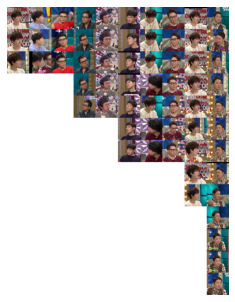

In [13]:
# 클러스터링(fingerprints) 후 결과 출력
clusters = calc.cluster(fingerprints, sim=0.55, min_csize=3) # 높일수록 엄격하게

postproc.make_links(clusters, os.path.join(result_dir, 'imagecluster/clusters'))

images = icio.read_images(result_dir, size=(224,224))

fig, ax = postproc.plot_clusters(clusters, images)
fig.savefig(os.path.join(result_dir, 'imagecluster/_cluster.png'))
postproc.plt.show()